In [1]:
import math
import warnings

import numba
import numpy as np
import matplotlib.pyplot as plt

In this notebook we follow some algorithms from [[2007:random-matrices]](https://arxiv.org/pdf/math-ph/0609050v2.pdf) to generate random matrices. Random matrices are used in various benchmark functions as rotation matrices.
The referenced source is cited in the reference implementation [[2008:shark]](https://github.com/Shark-ML/Shark/blob/d0b28e623ec2d3cf4bcb5f0a7f0739a23cc7c7aa/include/shark/LinAlg/rotations.h).

Other links for some background:

* https://en.wikipedia.org/wiki/Unitary_group
* https://en.wikipedia.org/wiki/Unitary_matrix

In [2]:
def verification_experiment(fn, rng, n=50, samples=10000):
    """Run an experiment (described in pp. 8-9) to plot the empirical eigenvalue density (a histogram)
    and the spacing distribution (a histogram as well)"""
    # Note: The Haar measure is the random matrix analogue to an uniform distribution
    #       The density of the eigenvalues should be uniform and equal to 1/2pi
    #       Furthermore, the distribution of the spacing distance 
    #       between the eigenvalues must fit the theoretical distribution.
    angles = np.zeros((samples, n))
    ss = np.zeros((samples, n-1))
    for i in range(samples):
        q = fn(n, rng)
        eig, _ = np.linalg.eig(q)
        angles[i, :] = np.sort(np.angle(eig))
        ss[i, :] = (n / (2. * np.pi)) * (angles[i, 1:] - angles[i, :-1])

    s_density, s_values = np.histogram(ss.flatten(), bins='auto', density=True)
    angle_density, angle_values = np.histogram(angles.flatten(), bins='auto', density=True)
    
    fig = plt.figure(figsize=(8, 4))
    axs = fig.subplots(1, 2)
    axs[0].plot(angle_values[:-1], angle_density, color='red', marker='x', linestyle='')
    axs[0].hlines(1. / (2. * np.pi), angle_values[0], angle_values[-1])
    axs[0].set_ylabel(r'$p(\theta)$')
    axs[0].set_xlabel(r'$\theta$')
    axs[0].set_ylim(0, 0.18)

    axs[1].plot(s_values[:-1], s_density, color='red', marker='x', linestyle='')
    # TODO: Find the theoretical definition of the spacing distribution to able to
    #       plot the reference against the empirical
    axs[1].set_ylabel(r'$p(s)$')
    axs[1].set_xlabel(r'$s$')
    
    return fig

In [6]:
def random_unitary_matrix_incorrect(n, rng):
    """Attempt (incorrectly) to generate a random unitary matrix with a distribution given
    by a Haar measure.
    
    Notes
    -----
    Introductory motivating example. See p.7 of [2007:random-matrices].
    """
    Z = (rng.standard_normal(size=(n,n)) + (1j * rng.standard_normal(size=(n,n)))) / np.sqrt(2.)
    Q , _ = np.linalg.qr(Z)
    return Q

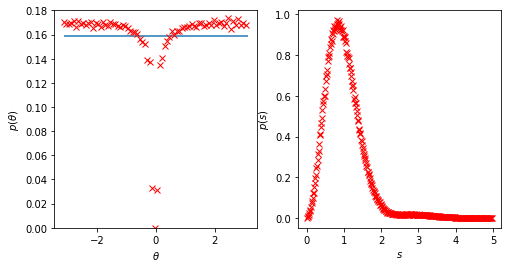

In [7]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_unitary_matrix_incorrect, rng, n=50, samples=10000)

In [8]:
def random_unitary_matrix(n, rng):
    """Generate a random unitary matrix with a distribution given by a Haar measure.
    
    Notes
    -----
    See pp. 11-12 of [2007:random-matrices]
    """
    Z = (rng.standard_normal(size=(n,n)) + (1j * rng.standard_normal(size=(n,n)))) / np.sqrt(2.)
    return random_unitary_matrix_jit(n, Z)

@numba.jit
def random_unitary_matrix_jit(n, Z):
    Q , r = np.linalg.qr(Z)
    d = np.diag(r)
    return Q * (d / np.abs(d)) @ Q

def random_unitary_matrix_nojit(n, rng):
    Z = (rng.standard_normal(size=(n,n)) + (1j * rng.standard_normal(size=(n,n)))) / np.sqrt(2.)
    Q , r = np.linalg.qr(Z)
    d = np.diag(r)
    return Q * (d / np.abs(d)) @ Q

In [9]:
# Numba complains about matrix multiplication
# (...) NumbaPerformanceWarning: '@' is faster on contiguous arrays (...)
warnings.filterwarnings("ignore", category=numba.NumbaPerformanceWarning)

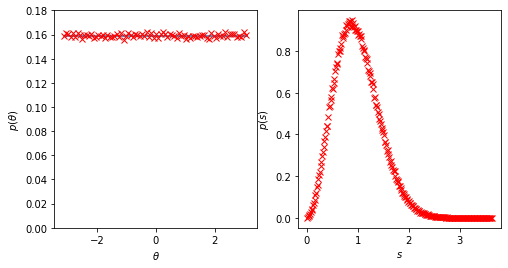

In [10]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_unitary_matrix, rng, n=50, samples=10000)

For the next algorithm, we need to build $$Q = H_n^T(\hat{v}_n) \tilde{H}^T_{n-1}(\hat{v}_{n-1}) \cdots \tilde{H}^T_{2}(\hat{v}_2) \tilde{H}^T_{1}(\hat{v}_1)$$.
 
Where $$\tilde{H}_{m} = \left( \begin{matrix} I_{n-m} & \, \\ \, & H_{m} \end{matrix} \right)$$
      $$H_m(\hat{v}) = \begin{cases}
                         -\text{sgn}(x_1) \left( I - 2 \hat{u} \hat{u}^T \right) & \hat{v} \neq e_1 \\
                         I_m & \hat{v} = e_1
                       \end{cases}
      $$
      $$\hat{u} = \frac{\hat{v} + \text{sgn}(x_1)e_1}{|| \hat{v} + \text{sgn}(x_1) e_1 ||}$$
      $$\hat{v} = \frac{v}{||v||}$$
      $$\text{sgn}(x) = \frac{x}{|x|} = \frac{|x|}{x}$$
      $$ m = 1 \cdots n$$

In [18]:
def random_orthogonal_matrix(n, rng):
    """Generate a random orthogonal matrix with distribution given by a Haar measure.
    
    Notes
    -----
    This algorithm is the one used in [2008:shark] because it is faster, we port the implementation here.
    See p. 16 from [2007:random-matrices]

    The benchmark functions (e.g. CIGTAB1) require an orthogonal rotation matrix [2007:mo-cma-es].
    So it suffices to use the variant of the algorithm that produces random matrices in O(N).
    """
    v = rng.standard_normal((n * n + n - 2) // 2)
    return random_orthogonal_matrix_jit(n, v)

@numba.njit
def random_orthogonal_matrix_jit(n, v):
    Q = np.eye(n)
    # We can safely skip the first iteration (see piece-wise definition above)
    k = 0
    for i in range(2, n+1):
        # Compute v_hat
        ki = k + i
        v[k:ki] /= np.linalg.norm(v[k:ki])
        # Compute u_hat
        sgn = v[k] / abs(v[k])
        v[k] += sgn
        tmp = v[k:ki]
        beta = 2. / np.sum(tmp * tmp)
        # Apply the Householder reflection
        Q[n-i:n, n-i:n] -= beta * np.outer(tmp, Q[n-i:n, n-i:n].T @ tmp)
        Q[n-i:n, n-i:n] *= -sgn
        k += i
    return Q

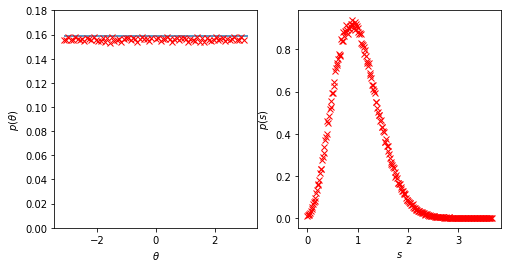

In [19]:
rng = np.random.default_rng(None)
fig = verification_experiment(random_orthogonal_matrix, rng, n=50, samples=10000)

Timing the algorithms:

In [20]:
rng = np.random.default_rng(None)
n = 10
%timeit random_unitary_matrix(n, rng)

42.6 µs ± 832 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
rng = np.random.default_rng(None)
n = 10
%timeit random_unitary_matrix_nojit(n, rng)

161 µs ± 851 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
rng = np.random.default_rng(None)
n = 10
%timeit random_orthogonal_matrix(n, rng)

20.3 µs ± 267 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
